## Imports

### Install packages

In [1]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

### Import modules

In [2]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux f8ec18aa6a94 6.12.5-linuxkit #1 SMP Tue Jan 21 10:23:32 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.1
arviz version=0.21.0
preliz version=0.4.1


In [4]:
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']) +
                  cycler(linestyle=['-', '--', ':', '-.']) + 
                  cycler(marker=['o', 'v', 'd', 'p']))

color=['0.3', '0.5', '0.7', '0.5']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('font', size=20)

In [8]:
# Chap1

In [5]:
dir_name = "/app/lectures_source/tutorial_msml610/notebooks/Lesson9-data"
!ls $dir_name

br_cities.csv		    prime_card.csv
cross_sell_email.csv	    prime_card_discontinuity.csv
daily_restaurant_sales.csv  rec_ab_test.csv
discount_data.csv	    risk_data.csv
email_obs_data.csv	    risk_data_rnd.csv
email_rnd_data.csv	    sb_exp_every.csv
enem_scores.csv		    sb_exp_opt.csv
interest_rate.csv	    short_offline_mkt_all_regions.csv
management_training.csv     short_offline_mkt_south.csv
offline_mkt_staggered.csv   spend_data.csv
online_classroom.csv	    spend_data_rnd.csv
online_mkt.csv		    wage.csv
online_mkt_cov.csv	    xmas_sales.csv


In [14]:
data = pd.read_csv(dir_name + "/xmas_sales.csv")
print(data.shape)
data.head(6)

(2000, 5)


,store,weeks_to_xmas,avg_week_sales,is_on_sale,weekly_amount_sold
0,1,3,12.98,1,219.60
1,1,2,12.98,1,184.70
2,1,1,12.98,1,145.75
3,1,0,12.98,0,102.45
4,2,3,19.92,0,103.22
5,2,2,19.92,0,53.73


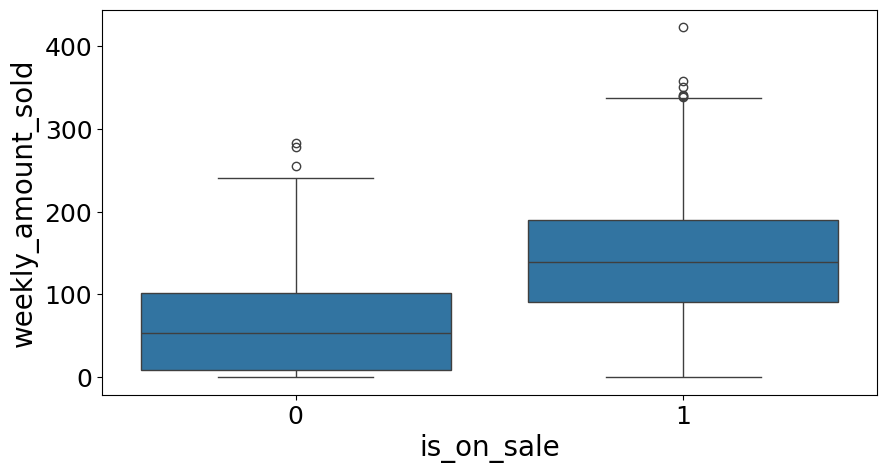

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.boxplot(y="weekly_amount_sold", x="is_on_sale", data=data, ax=ax)

ax.set_xlabel("is_on_sale", fontsize=20)
ax.set_ylabel("weekly_amount_sold", fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=18)

In [26]:
# i = unit identifier
# y0, y1 = outcomes under control and treatment
# t = treatment indicator
# x = group
df1 = pd.DataFrame(dict(
    i= [1,2,3,4,5,6],
    y0=[200,120,300, 450,600,600],
    y1=[220,140,400, 500,600,800],
    t= [0,0,0,1,1,1],
    x= [0,0,1,0,0,1],
))
df1

,i,y0,y1,t,x
0,1,200,220,0,0
1,2,120,140,0,0
2,3,300,400,0,1
3,4,450,500,1,0
4,5,600,600,1,0
5,6,600,800,1,1


In [23]:
# Select the outcome based on the treatment.
df1["y"] = (df1["t"]*df1["y1"] + (1-df1["t"])*df1["y0"]).astype(int)

# Treatment effect.
df1["te"] = df1["y1"] - df1["y0"]

df1

,i,y0,y1,t,x,y,te
0,1,200,220,0,0,200,20
1,2,120,140,0,0,120,20
2,3,300,400,0,1,300,100
3,4,450,500,1,0,500,50
4,5,600,600,1,0,600,0
5,6,600,800,1,1,800,200


In [25]:
df2 = pd.DataFrame(dict(
    i= [1,2,3,4,5,6],
    y0=[200,120,300, np.nan, np.nan, np.nan,],
    y1=[np.nan, np.nan, np.nan, 500,600,800],
    t= [0,0,0,1,1,1],
    x= [0,0,1,0,0,1]))
df2

,i,y0,y1,t,x
0,1,200.0,NaN,0,0
1,2,120.0,NaN,0,0
2,3,300.0,NaN,0,1
3,4,NaN,500.0,1,0
4,5,NaN,600.0,1,0
5,6,NaN,800.0,1,1


In [ ]:
# Select the outcome based on the treatment.
df2["y"] = (df2["t"]*df2["y1"] + (1-df2["t"])*df2["y0"]).astype(int)

# Treatment effect.
df2["te"] = df2["y1"] - df2["y0"]

df2

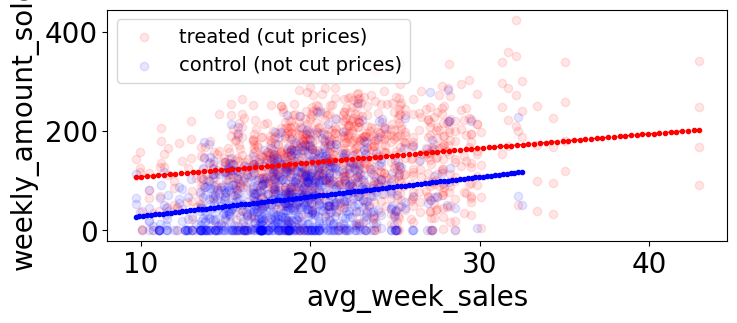

In [55]:
plt.rc('font', size=20)
fig = plt.figure()    

# sns.lmplot(data=data,
#            ci=None,
#            x="avg_week_sales",
#            y="weekly_amount_sold",
#            scatter=False,
#            height=4, aspect=2)

df_treated = data.query("is_on_sale==1")
sns.regplot(data=df_treated,
           ci=None,
           x="avg_week_sales",
           y="weekly_amount_sold",
           scatter=False,
           line_kws={'color': 'red',
                     'linewidth': 1, 'linestyle': '--', "marker": "."})
plt.scatter(x=df_treated["avg_week_sales"],
            y=df_treated["weekly_amount_sold"],
            label="treated (cut prices)",
            color="red", alpha=.1, marker=marker[0])

df_control = data.query("is_on_sale==0")
sns.regplot(data=df_control,
           ci=None,
           x="avg_week_sales",
           y="weekly_amount_sold",
           scatter=False,
           line_kws={'color': 'blue',
                     'linewidth': 1, 'linestyle': '--', "marker": "."})

plt.scatter(x=df_control["avg_week_sales"],
            y=df_control["weekly_amount_sold"],
            label="control (not cut prices)",
            color="blue", alpha=.1, marker=marker[0])

plt.legend(fontsize="14");

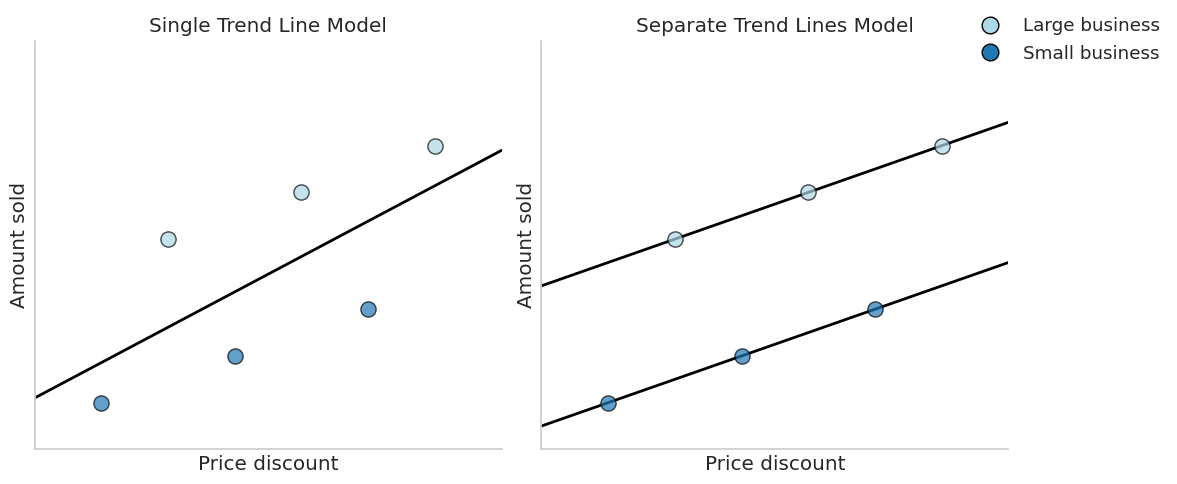

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Create synthetic data
np.random.seed(42)

# Generate data for large businesses
large_discount = np.array([0.1, 0.2, 0.3])
large_amount = np.array([8, 12, 16]) + 10

# Generate data for small businesses
small_discount = np.array([0.05, 0.15, 0.25])
small_amount = np.array([4, 8, 12])

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Single trend line
ax1.set_title('Single Trend Line Model')
ax1.set_xlabel('Price discount')
ax1.set_ylabel('Amount sold')

# Scatter plots
ax1.scatter(large_discount, large_amount, s=120, color='lightblue', edgecolor='black', alpha=0.7, zorder=2)
ax1.scatter(small_discount, small_amount, s=120, color='#1f77b4', edgecolor='black', alpha=0.7, zorder=2)

# Combine data for single trend line
all_discount = np.concatenate([large_discount, small_discount])
all_amount = np.concatenate([large_amount, small_amount])

# Calculate and plot the trend line
z = np.polyfit(all_discount, all_amount, 1)
p = np.poly1d(z)
x_line = np.linspace(0, 0.35, 100)
ax1.plot(x_line, p(x_line), 'k-', linewidth=2, zorder=1)

# Plot 2: Separate trend lines
ax2.set_title('Separate Trend Lines Model')
ax2.set_xlabel('Price discount')
ax2.set_ylabel('Amount sold')

# Scatter plots (same as plot 1)
ax2.scatter(large_discount, large_amount, s=120, color='lightblue', edgecolor='black', alpha=0.7, zorder=2)
ax2.scatter(small_discount, small_amount, s=120, color='#1f77b4', edgecolor='black', alpha=0.7, zorder=2)

# Calculate and plot separate trend lines
z_large = np.polyfit(large_discount, large_amount, 1)
p_large = np.poly1d(z_large)
ax2.plot(x_line, p_large(x_line), 'k-', linewidth=2, zorder=1)

z_small = np.polyfit(small_discount, small_amount, 1)
p_small = np.poly1d(z_small)
ax2.plot(x_line, p_small(x_line), 'k-', linewidth=2, zorder=1)

# Remove top and right spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(0, 0.35)
    ax.set_ylim(0, 35)
    # Remove tick marks
    ax.tick_params(axis='both', which='both', length=0)
    # Remove numerical ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Create legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
           markeredgecolor='black', markersize=12, label='Large business'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', 
           markeredgecolor='black', markersize=12, label='Small business'),
]

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.99, 0.99))

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

# Simpson paradox

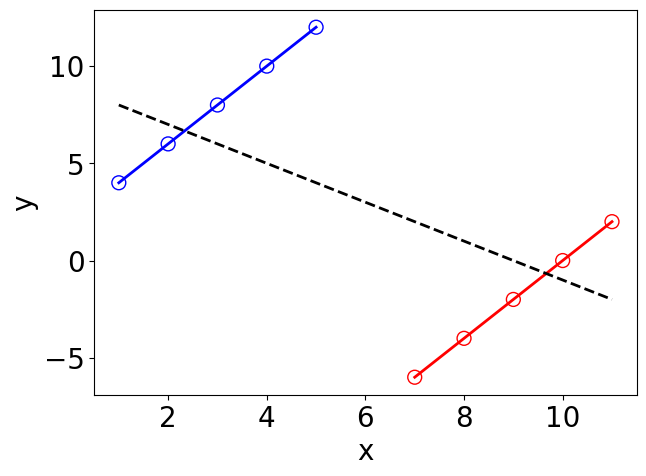

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Generate synthetic data
x1 = np.array([1, 2, 3, 4, 5])
y1 = 2 * x1 + 2  # Positive trend
x2 = np.array([7, 8, 9, 10, 11])
y2 = 2 * x2 - 20  # Positive trend but different intercept

# Combine the data
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
group = ['blue'] * len(x1) + ['red'] * len(x2)

# Create a DataFrame
df = pd.DataFrame({'x': x, 'y': y, 'group': group})

# Fit separate linear models for each group
model_blue = LinearRegression().fit(x1.reshape(-1, 1), y1)
model_red = LinearRegression().fit(x2.reshape(-1, 1), y2)

# Fit an overall model ignoring group distinction
model_all = LinearRegression().fit(x.reshape(-1, 1), y)

# Create a plot
plt.figure(figsize=(7, 5))

# Plot data points
plt.scatter(df[df['group'] == 'blue']['x'], df[df['group'] == 'blue']['y'], edgecolor='blue', facecolor='none', s=100, label='Group Blue')
plt.scatter(df[df['group'] == 'red']['x'], df[df['group'] == 'red']['y'], edgecolor='red', facecolor='none', s=100, label='Group Red')

# Plot group regression lines
plt.plot(x1, model_blue.predict(x1.reshape(-1, 1)), color='blue', linewidth=2)
plt.plot(x2, model_red.predict(x2.reshape(-1, 1)), color='red', linewidth=2)

# Plot overall regression line
x_range = np.linspace(min(x), max(x), 100)
plt.plot(x_range, model_all.predict(x_range.reshape(-1, 1)), 'k--', linewidth=2, label='Overall Trend')

# Labels and legend
plt.xlabel('x')
plt.ylabel('y')
#plt.legend(font=5)
plt.show()
